# Blind source separation with an unsupervised autoencoder

# Daniel Correa Tucunduva 


## Setup

In [1]:
# Module setup

import numpy as np
from scipy.ndimage import gaussian_filter
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from sklearn.decomposition import FastICA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

print(__doc__)

Using TensorFlow backend.


Automatically created module for IPython interactive environment


## Synthetic data generation

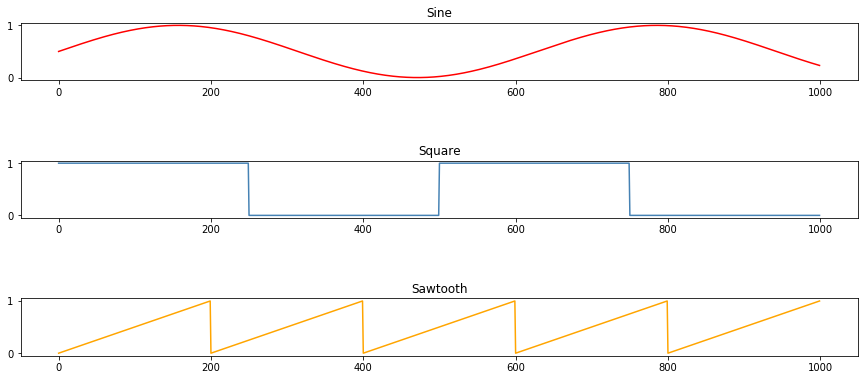

In [2]:
grid = np.zeros([10, 10])

src_loc_1 = [3, 3]
src_loc_2 = [5, 7]
src_loc_3 = [8, 2]

src_1 = np.sin(np.arange(0, 1000, 0.01))  # sin

src_2 = np.zeros(src_1.shape[0])  # box
for i in np.arange(0, src_2.shape[0], 500):
    src_2[i:i + 250] = 1

src_3 = np.zeros(src_1.shape[0])  # sawtooth
for i in np.arange(0, src_3.shape[0], 200):
    src_3[i:i + 200] = np.arange(0, 200) / 200

src_1 = np.reshape(src_1, [100000, 1])
src_2 = np.reshape(src_2, [100000, 1])
src_3 = np.reshape(src_3, [100000, 1])

scaler = MinMaxScaler(feature_range=(0, 1))
src_1 = scaler.fit_transform(src_1)
src_2 = scaler.fit_transform(src_2)
src_3 = scaler.fit_transform(src_3)

track_1 = np.reshape(src_1, [100000, 1])
track_2 = np.reshape(src_2, [100000, 1])
track_3 = np.reshape(src_3, [100000, 1])

plt.figure(figsize=(15, 15))

models = [track_1[0:1000], track_2[0:1000], track_3[0:1000]]
names = ['Sine', 'Square', 'Sawtooth']
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(12, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, [colors[index - 1]]):
        plt.plot(sig, color=color)

plt.show()

In [3]:
def smooth_src(input_signal, sigma):
    print('smoothing...')
    for i in np.arange(0, input_signal.shape[2]):
        input_signal[:, :, i] = gaussian_filter(input_signal[:, :, i], sigma)

    return input_signal

src_grid_1 = np.zeros([10, 10, src_1.shape[0]])  # init 3d grid
src_grid_1[src_loc_1[0], src_loc_1[1], :] = src_1[:,0]  # place point source in grid
src_grid_1 = smooth_src(src_grid_1, 3)  # smooth

src_grid_2 = np.zeros([10, 10, src_2.shape[0]])
src_grid_2[src_loc_2[0], src_loc_2[1], :] = src_2[:,0]
src_grid_2 = smooth_src(src_grid_2, 3)

src_grid_3 = np.zeros([10, 10, src_3.shape[0]])
src_grid_3[src_loc_3[0], src_loc_3[1], :] = src_3[:,0]
src_grid_3 = smooth_src(src_grid_3, 3)

mixed = src_grid_1 + src_grid_2 + src_grid_3  # goal is to unmix mixed
"""
the matrix 'mixed' is the sum of all 3 sources, where each source is a 2d gaussian
smoothed time series (sin, boxcar, sawtooth). the goal is to recover the original
time series, as well as the spatial topography of the original sources  
"""

reshape_mixed = np.reshape(mixed, [100, mixed.shape[2]])
ica = FastICA(n_components=3)  # we'll be generous and assume there's 3
ica.fit(reshape_mixed.T)  # .T because 100000 instances, 100 attributes
ica_comps = ica.transform(reshape_mixed.T)  # get the components
ica_weights = np.reshape(ica.components_.T, [10, 10, 3])  # visualize these as images

smoothing...
smoothing...
smoothing...


## Autoencoder training

In [4]:
autoencoder = Sequential()
autoencoder.name = 'autoencoder'
autoencoder.add(Dense(3, activation='linear', input_shape=[100], kernel_initializer='random_uniform', use_bias=False, kernel_constraint='nonneg'))
autoencoder.add(Dense(100, activation='linear', kernel_initializer='random_uniform', use_bias=False, kernel_constraint='nonneg'))

autoencoder.summary()

autoencoder.compile(loss='logcosh', optimizer='adam')

autoencoder_input = reshape_mixed.T

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 300       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               300       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [5]:
dense_broad_history = autoencoder.fit(autoencoder_input,
                                      autoencoder_input,
                                      batch_size=40,
                                      epochs=100,
                                      verbose=1)

Epoch 1/100
100000/100000 [==============================] - 3s 27us/step - loss: 6.2160e-06
Epoch 2/100
100000/100000 [==============================] - 3s 25us/step - loss: 8.7834e-08
Epoch 3/100
100000/100000 [==============================] - 3s 25us/step - loss: 4.2757e-08
Epoch 4/100
100000/100000 [==============================] - ETA: 0s - loss: 2.9858e-0 - 3s 25us/step - loss: 2.9804e-08
Epoch 5/100
100000/100000 [==============================] - 3s 25us/step - loss: 2.3544e-08
Epoch 6/100
100000/100000 [==============================] - 3s 25us/step - loss: 2.0291e-08
Epoch 7/100
100000/100000 [==============================] - 3s 25us/step - loss: 1.8349e-08
Epoch 8/100
100000/100000 [==============================] - 3s 30us/step - loss: 1.7165e-08
Epoch 9/100
100000/100000 [==============================] - 3s 27us/step - loss: 1.6483e-08
Epoch 10/100
100000/100000 [==============================] - 3s 25us/step - loss: 1.5931e-08
Epoch 11/100
100000/100000 [=============

100000/100000 [==============================] - 3s 28us/step - loss: 1.0332e-08
Epoch 87/100
100000/100000 [==============================] - ETA: 0s - loss: 1.0272e-0 - 3s 28us/step - loss: 1.0274e-08
Epoch 88/100
100000/100000 [==============================] - 3s 26us/step - loss: 1.0277e-08
Epoch 89/100
100000/100000 [==============================] - 3s 27us/step - loss: 1.0320e-08
Epoch 90/100
100000/100000 [==============================] - 3s 26us/step - loss: 1.0299e-08
Epoch 91/100
100000/100000 [==============================] - 3s 26us/step - loss: 1.0294e-08
Epoch 92/100
100000/100000 [==============================] - 3s 26us/step - loss: 1.0268e-08
Epoch 93/100
100000/100000 [==============================] - 3s 27us/step - loss: 1.0280e-08
Epoch 94/100
100000/100000 [==============================] - 3s 26us/step - loss: 1.0251e-08
Epoch 95/100
100000/100000 [==============================] - 3s 27us/step - loss: 1.0261e-08
Epoch 96/100
100000/100000 [=================

In [6]:
reconstruction = autoencoder.predict(autoencoder_input)

## Original and reconstruction comparison

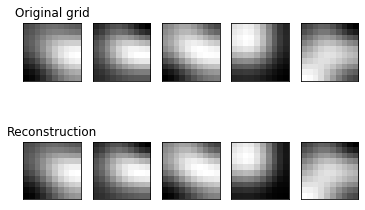

In [7]:
i = 1
for ii in [0, 50, 210, 400, 740]:
    ax = plt.subplot(2, 5, i)
    if i == 1:
        plt.title('Original grid')
    plt.imshow(np.reshape(autoencoder_input[ii], [10, 10]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 5, i + 5)
    if i == 1:
        plt.title('Reconstruction')
    plt.imshow(np.reshape(reconstruction[ii], [10, 10]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1

## Recover independent sources from hidden layer

In [8]:
hidden_layer = Sequential()
hidden_layer.name = 'hidden_layer'
hidden_layer.add(Dense(3, input_shape=[100], use_bias=False, kernel_constraint='nonneg'))
hidden_layer.summary()

hidden_layer.set_weights(autoencoder.get_weights())

recovered_sources = hidden_layer.predict(reshape_mixed.T)

source_1 = np.reshape(recovered_sources.T[0], [100000, 1])
source_2 = np.reshape(recovered_sources.T[1], [100000, 1])
source_3 = np.reshape(recovered_sources.T[2], [100000, 1])

recovered_sources = np.concatenate([source_1, source_2, source_3], axis=1)

Model: "hidden_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3)                 300       
Total params: 300
Trainable params: 300
Non-trainable params: 0
_________________________________________________________________


## ICA and autoencoder results comparison

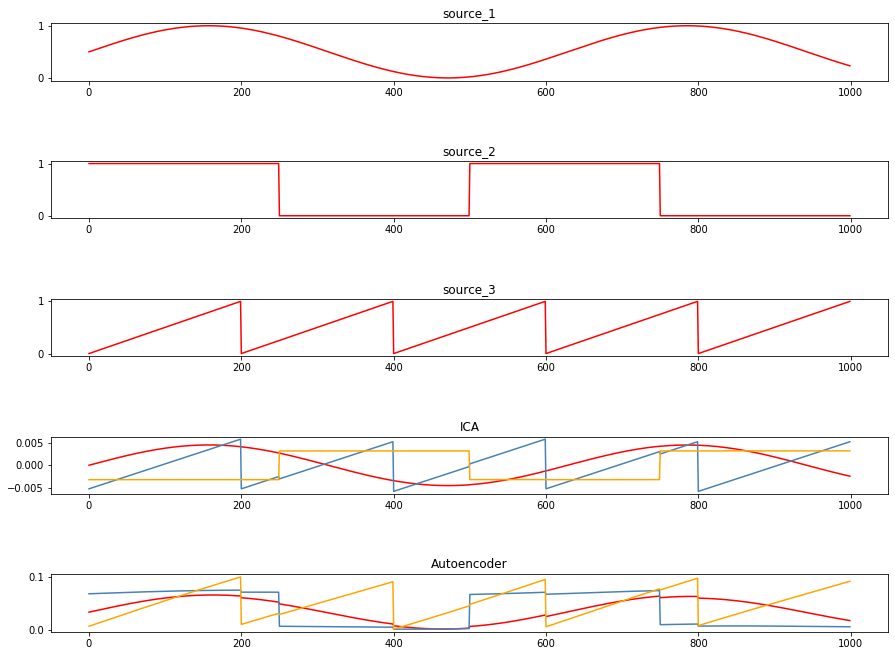

In [9]:
plt.figure(figsize=(15, 15))

models = [
    track_1[0:1000],
    track_2[0:1000],
    track_3[0:1000],
    ica_comps[0:1000],
    recovered_sources[0:1000]
]
names = ['source_1', 'source_2', 'source_3', 'ICA',  'Autoencoder']
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(12, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.show()